<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/41_hier_poisson.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

(hier_poisson_model)=
# Modello gerarchico di Poisson

In questo capitolo, proseguiremo la discussione sul modello gerarchico bayesiano utilizzando PyMC, concentrandoci questa volta sul caso in cui i dati seguono una distribuzione di Poisson.

Esaminiamo il problema di determinare quanti pazienti segue in media uno psicologo professionista. Il numero medio di casi per uno psicologo può variare considerevolmente, in base alle aree di specializzazione, all'ambiente di lavoro e al numero di ore che lo psicologo decide di lavorare ogni settimana. Una ricerca condotta dall'American Psychological Association (APA) rivela che quasi il 42% dei psicologi negli Stati Uniti lavora, in media, tra le 40 e le 49 ore a settimana. Ciò indica che la maggior parte degli psicologi a tempo pieno ha un carico di lavoro che varia tra i 15 e i 20 clienti in un determinato momento.

In questo capitolo, esamineremo il modello gerarchico di Poisson utilizzando dati simulati. Immagineremo che i dati siano frutto di una ricerca condotta attraverso interviste a 30 psicologi, selezionati casualmente dall'Ordine degli Psicologi, in cinque regioni italiane. Durante le interviste, viene chiesto a ciascun psicologo quanti pazienti stia seguendo al momento.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import scipy.stats as stats
from scipy.stats import gaussian_kde
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

from aquarel import load_theme
theme = load_theme("minimal_light")
theme.apply()
sns.set_palette("colorblind")

## Preparazione del notebook

Importiamo un set di dati simulati. La variabile `location` fornisce un codice numerico identificativo per cinque diverse regioni italiane in cui sono stati effettuati i rilevamenti dei dati. La variabile `patients` indica il numero di pazienti seguiti da ciascuno dei 30 psicologi intervistati in ciascuna delle cinque regioni. 

In [3]:
dat = pd.read_csv("../data/patients.csv")
print(dat.head())

   patients  location
0        12         1
1        12         1
2         6         1
3        13         1
4        12         1


In [220]:
dat.shape

(150, 2)

In [221]:
dat.value_counts("location")

location
1    30
2    30
3    30
4    30
5    30
Name: count, dtype: int64

Creiamo un istogramma che rappresenti le frequenze assolute ignorando la suddivisione in regioni.

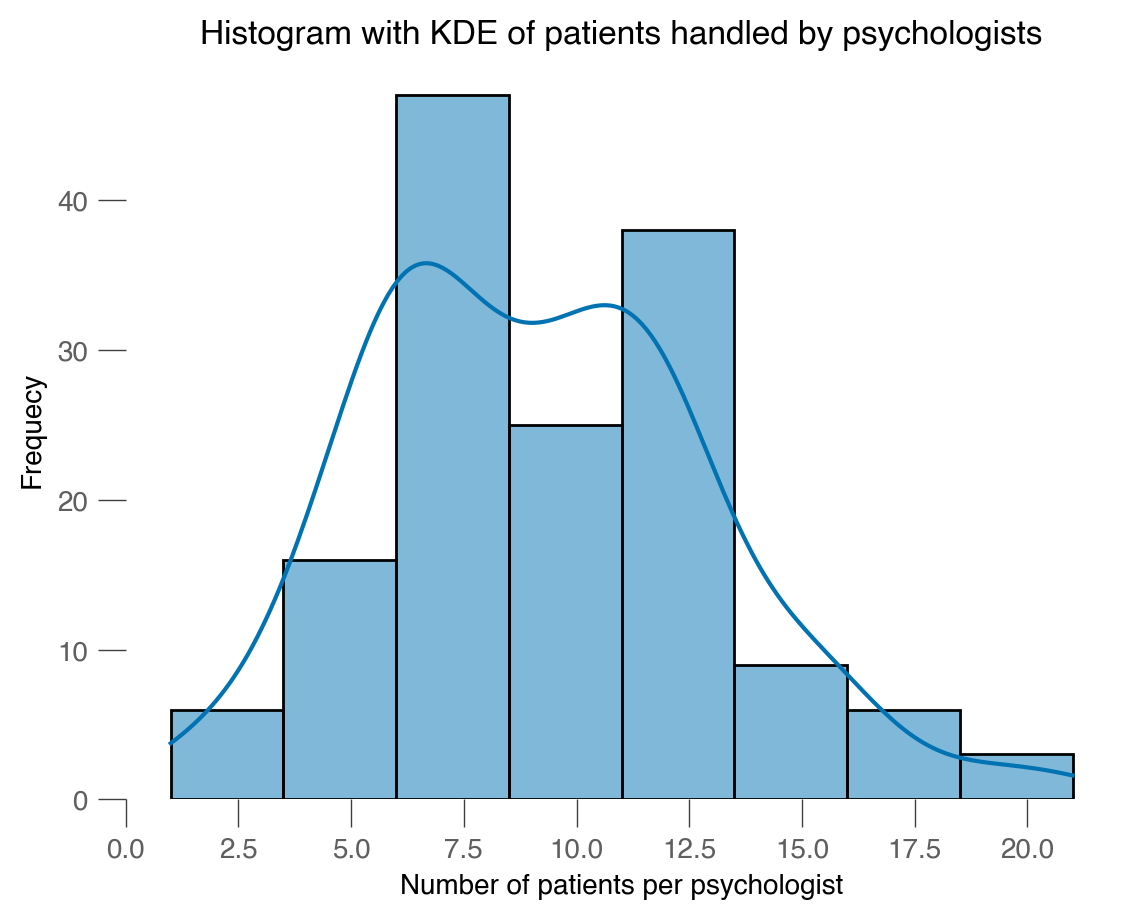

In [4]:
sns.histplot(data=dat, x="patients", bins=8, kde=True)
plt.xlabel("Number of patients per psychologist")
plt.ylabel("Frequecy")
plt.title("Histogram with KDE of patients handled by psychologists");

Esaminiamo gli istogrammi separatamente per ciascuna regione.

/Users/corrado/mambaforge/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


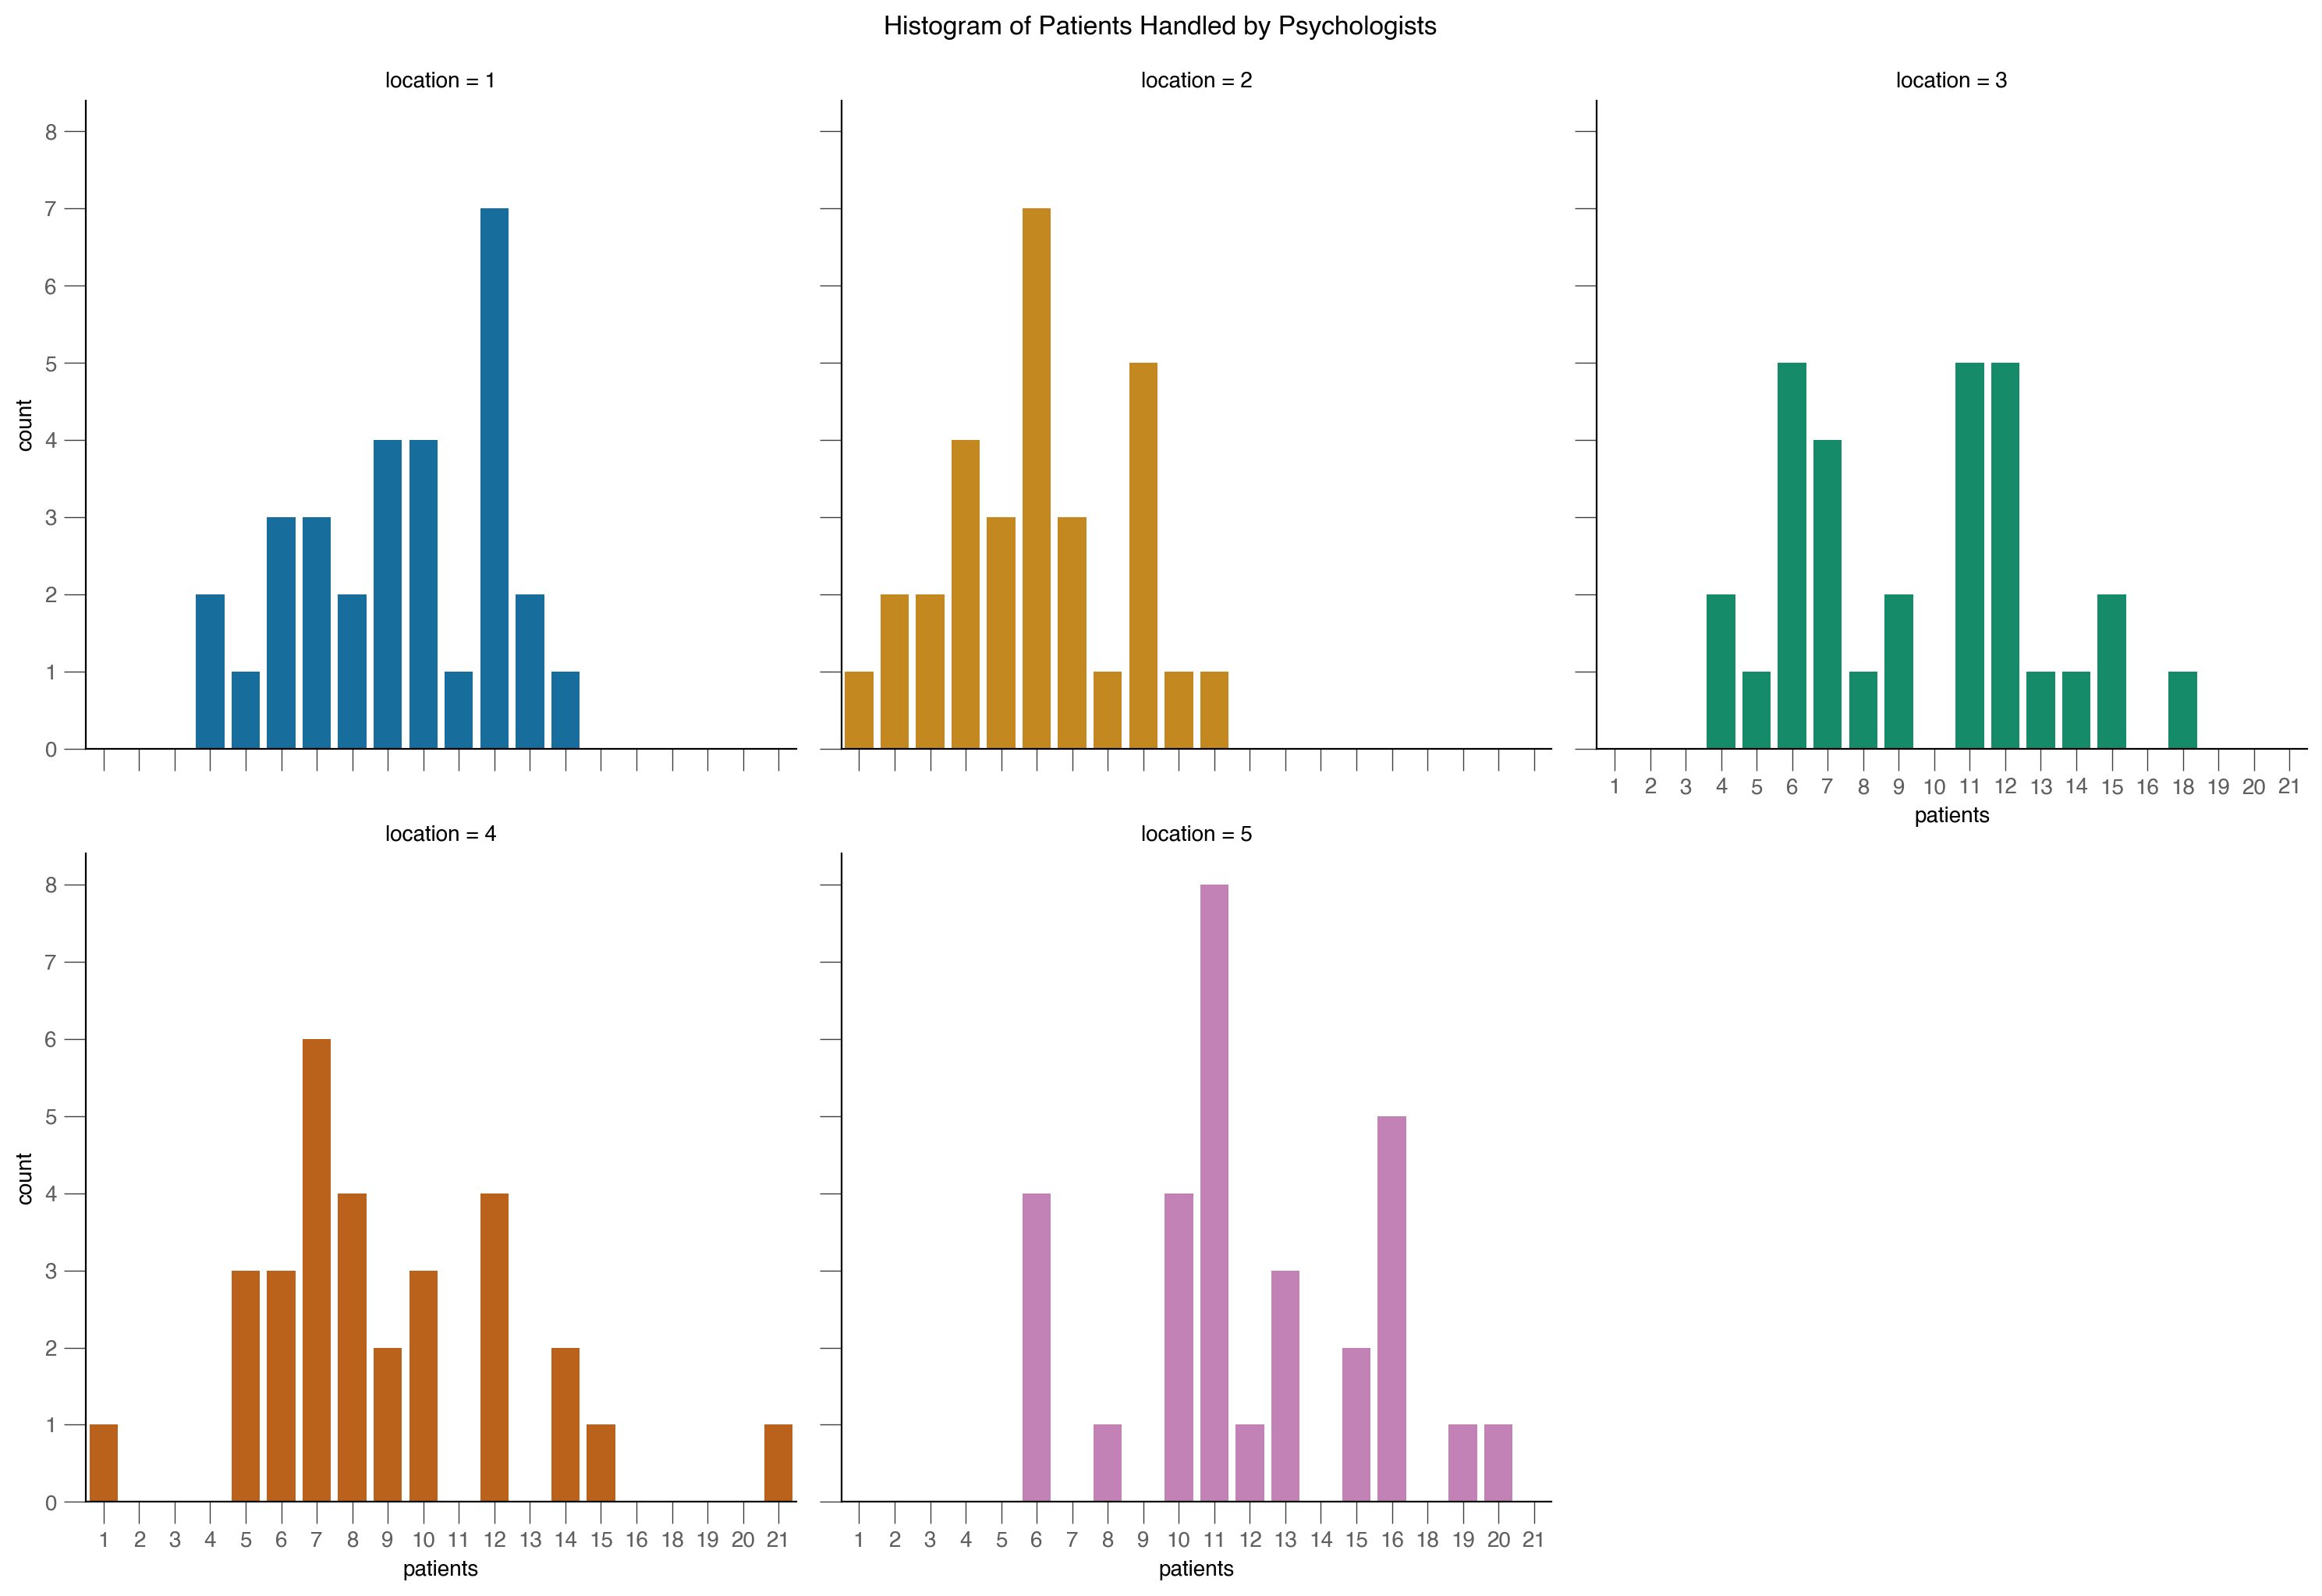

In [5]:
g = sns.catplot(
    x="patients",
    data=dat,
    col="location",
    hue="location",
    kind="count",
    dodge=False,
    col_wrap=3,
)
g.fig.suptitle("Histogram of Patients Handled by Psychologists", y=1.02);

Considereremo per i dati campionari una verosimiglianza di Poisson. Rappresentiamo qui graficamente 

## Modello con pooling completo

Iniziamo il nostro processo di modellazione considerando un modello che tralascia l'informazione sul raggruppamento dei dati nelle 5 regioni diverse. Tale modello è basato sulle seguenti componenti:

1. **Verosimiglianza di Poisson**: Supponiamo che la variabile `patients`, che rappresenta il numero di pazienti seguiti da ciascuno degli psicologi, segua una distribuzione di Poisson. Il parametro di questa distribuzione, denominato `rate`, è sconosciuto e sarà oggetto di stima.
2. **Distribuzione Gamma per il parametro `rate`**: Per modellare la nostra incertezza riguardo al parametro `rate`, utilizziamo una distribuzione a priori Gamma. In PyMC, la distribuzione Gamma è caratterizzata da due parametri, $\mu$ e $\sigma$.
3. **Ipotesi sugli iper-parametri $\mu$ e $\sigma$**: Invece di fissare numericamente i valori di $\mu$ e $\sigma$, trattiamo questi come degli iper-parametri, e impieghiamo distribuzioni di densità per descrivere la nostra incertezza su di essi. Poiché entrambi i parametri sono positivi, utilizziamo delle distribuzioni normali troncate sulla parte positiva e centrate sullo zero. Specificamente, scegliamo una deviazione standard di 10 per $\mu$ e di 20 per $\sigma$.

Il codice PyMC corrispondente a questo modello è il seguente:

In [9]:
patients = dat["patients"].values

In [9]:
with pm.Model() as model_pooling:
    h_mu = pm.HalfNormal("h_mu", sigma=10)      # Iper-parametro per la media della Gamma
    h_sigma = pm.HalfNormal("h_sigma", sigma=20) # Iper-parametro per la deviazione standard della Gamma
    rate = pm.Gamma("rate", mu=h_mu, sigma=h_sigma) # Parametro della verosimiglianza di Poisson
    y_obs = pm.Poisson("y_obs", mu=rate, observed=patients) # Verosimiglianza di Poisson

Eseguiamo il prior preditive check.

In [10]:
with model_pooling:
    idata_pooling_prior_pred = pm.sample_prior_predictive(samples=100, random_seed=rng)

Sampling: [h_mu, h_sigma, rate, y_obs]


I valori della distribuzione predittiva a priori sono contenuti nell'oggetto `idata_pooling_prior_pred`.

In [11]:
idata_pooling_prior_pred

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

Li possiamo estrarre nel modo seguente. Si noti che sono contenuti in un array di dimensioni 1 x 100 x 150.

In [12]:
foo = idata_pooling_prior_pred.prior_predictive.y_obs
foo.shape

(1, 100, 150)

Possiamo trasformare questo array in un vettore unidimensionale nel modo seguente.

In [13]:
# Extract the likelihood samples
likelihood_samples = idata_pooling_prior_pred.prior_predictive.y_obs
flattened_array = np.ravel(likelihood_samples.values)

print(flattened_array)

[ 0  0  0 ... 14 10 14]


A qusto punto possiamo creare il grafico per il prior preditive check.

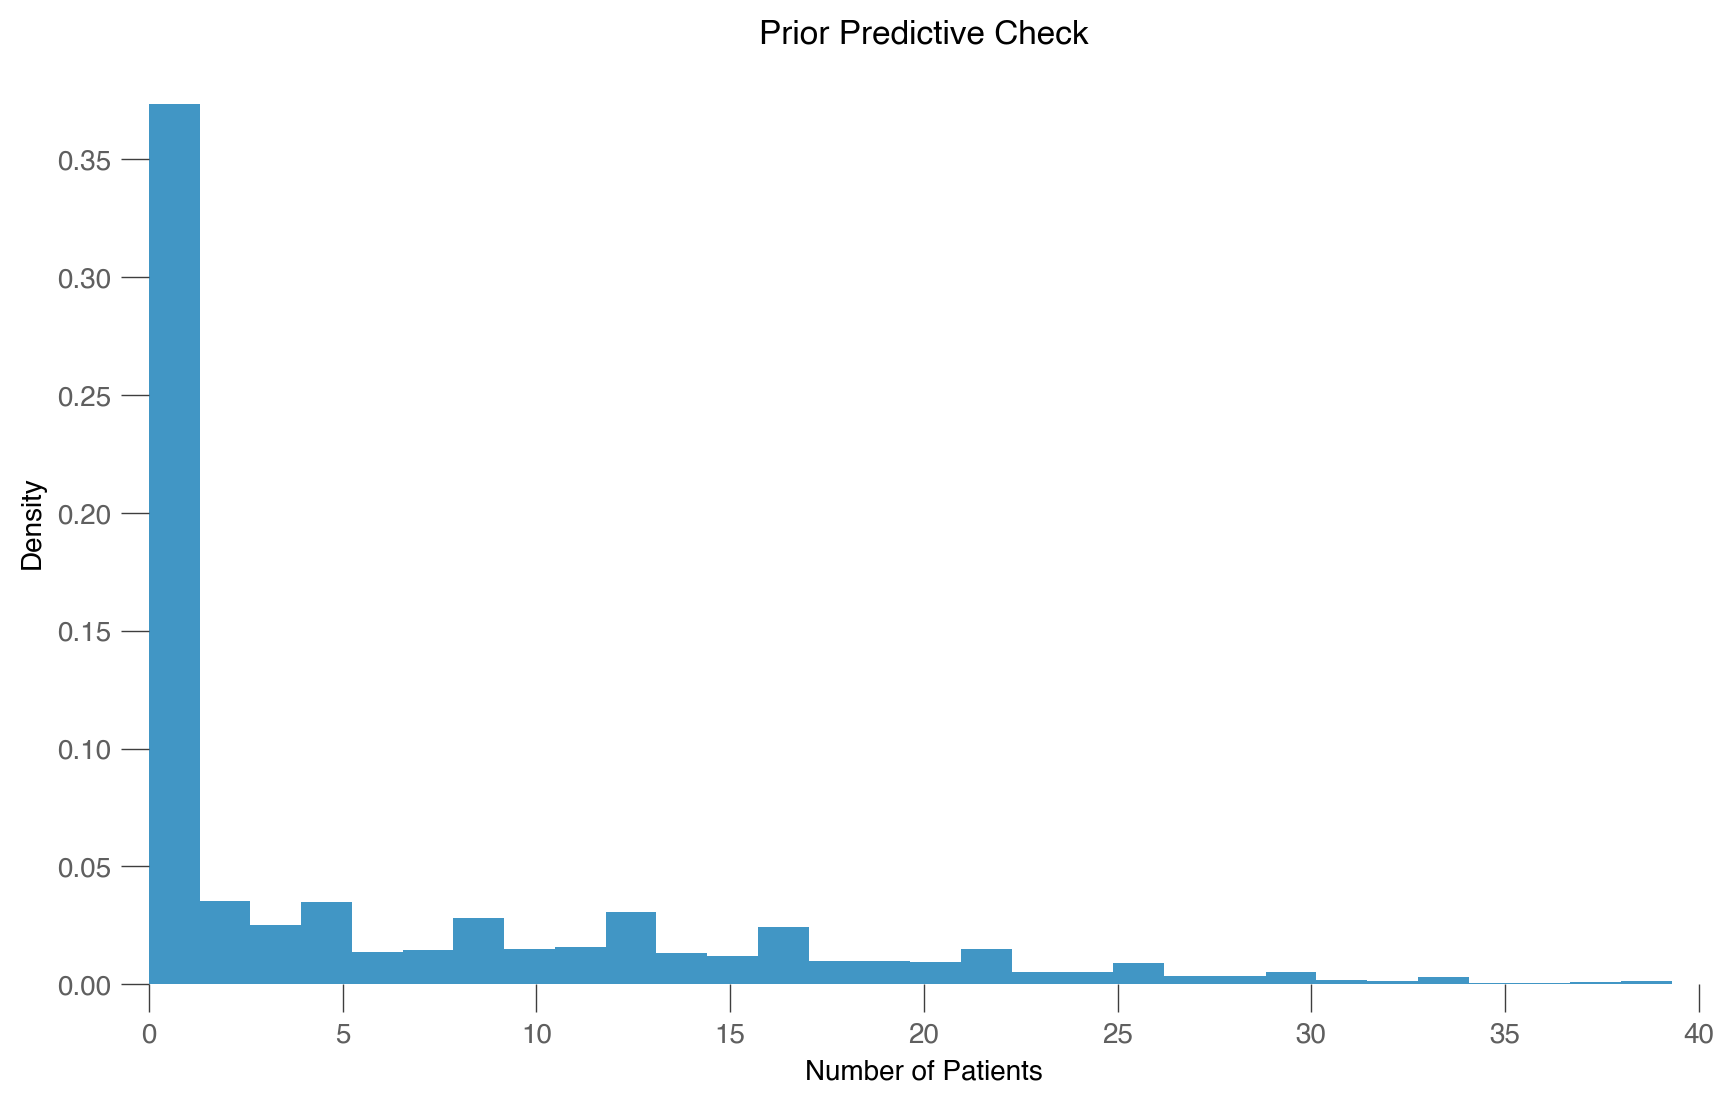

In [14]:
# Plot the prior predictive samples
plt.hist(flattened_array, bins=100, density=True, alpha=0.75)
plt.xlabel('Number of Patients')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.xlim(0, 40);

Si noti che le distribizioni a priori scelte sono adeguete per rappresentare i dati osservati che corrispondono ad un tasso medio pari a 10.

Eseguiamo ora il campionamento con il modello di pooling completo. Usiamo il sampling JAX per velocizzare il processo.

In [15]:
with model_pooling:
    idata_pooling = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:02.022955
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 584.18it/s]


Sampling time =  0:00:03.843868
Transforming variables...
Transformation time =  0:00:00.026530


Esaminiamo un sommario delle distribuzioni a posteriori.

In [16]:
az.summary(idata_pooling)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h_mu,10.429,4.313,2.935,19.214,0.096,0.068,1896.0,1285.0,1.01
h_sigma,9.117,8.727,0.197,25.848,0.256,0.181,378.0,163.0,1.01
rate,9.166,0.248,8.710,9.644,0.006,0.004,1541.0,1307.0,1.01


Questo modello suggerisce che ogni psicologo ha un numero medio di pazienti pari a 10.5 con un intervallo di credibilità al 94% pari a [2.7, 18.9].

## Modello gerarchico

Implementiamo ora un modello gerarchico che tiene in considerazione il ragruppamento dei dati.  

Iniziamo a definire delle variabili e coordinate necessarie per specificare la forma delle diverse distribuzioni di densità.

In [6]:
location_idx, locations = dat["location"].factorize(sort=True)
COORDS = {"obs": dat.index, "location": locations}

In [7]:
print(COORDS)

{'obs': RangeIndex(start=0, stop=150, step=1), 'location': Index([1, 2, 3, 4, 5], dtype='int64')}


Ora definiamo un modello gerarchico, che estende l'approccio precedente per considerare le differenti regioni all'interno dei dati. Questo passaggio è fondamentale se vogliamo ottenere stime separate dei parametri per ciascuna delle 5 regioni fittizie, anziché una stima comune. Ecco come si struttura il modello:

1. **Iper-parametri**: Come prima, definiamo gli iper-parametri `h_mu` e `h_sigma` usando delle distribuzioni normali troncate, con deviazioni standard di 10 e 20 rispettivamente.
2. **Distribuzione Gamma per `lam`**: Introduciamo la variabile `lam`, che ha una distribuzione Gamma con parametri di media `h_mu` e deviazione standard `h_sigma`. La chiave `dims="location"` indica che `lam` è una variabile multidimensionale con una dimensione per ogni regione, permettendo stime separate per ciascuna delle 5 regioni.
3. **Verosimiglianza dei Dati**: La verosimiglianza è ancora modellata come una distribuzione di Poisson. Utilizziamo `lam[location_idx]` per selezionare il valore corrispondente di `lam` per ogni osservazione, in base alla regione associata. Il parametro `dims="obs"` assicura che la verosimiglianza sia definita per ogni osservazione nei dati.

Il codice PyMC che implementa questo modello è il seguente.

In [10]:
with pm.Model(coords=COORDS) as model:
    h_mu = pm.HalfNormal("h_mu", sigma=10)               # Iper-parametro per la media della Gamma
    h_sigma = pm.HalfNormal("h_sigma", sigma=20)          # Iper-parametro per la deviazione standard della Gamma
    lam = pm.Gamma("lam", mu=h_mu, sigma=h_sigma, dims="location") # Parametri della verosimiglianza per ciascuna regione
    rate = lam[location_idx]                              # Selezione del tasso corrispondente per ogni osservazione
    y_obs = pm.Poisson("y_obs", mu=rate, observed=patients, dims="obs") # Verosimiglianza di Poisson

Questo modello gerarchico è più sofisticato e permette di catturare la struttura regionale nei dati, fornendo stime separate dei parametri per ciascuna delle 5 regioni.

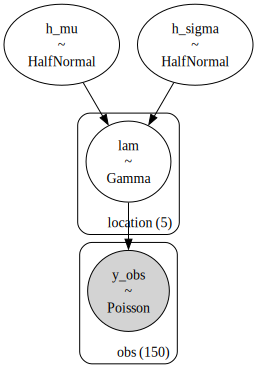

In [11]:
pm.model_to_graphviz(model)

Anche in questo caso, iniziamo con il prior predictive check.

In [12]:
with model:
    idata_prior_pred = pm.sample_prior_predictive(samples=100, random_seed=rng)

Sampling: [h_mu, h_sigma, lam, y_obs]


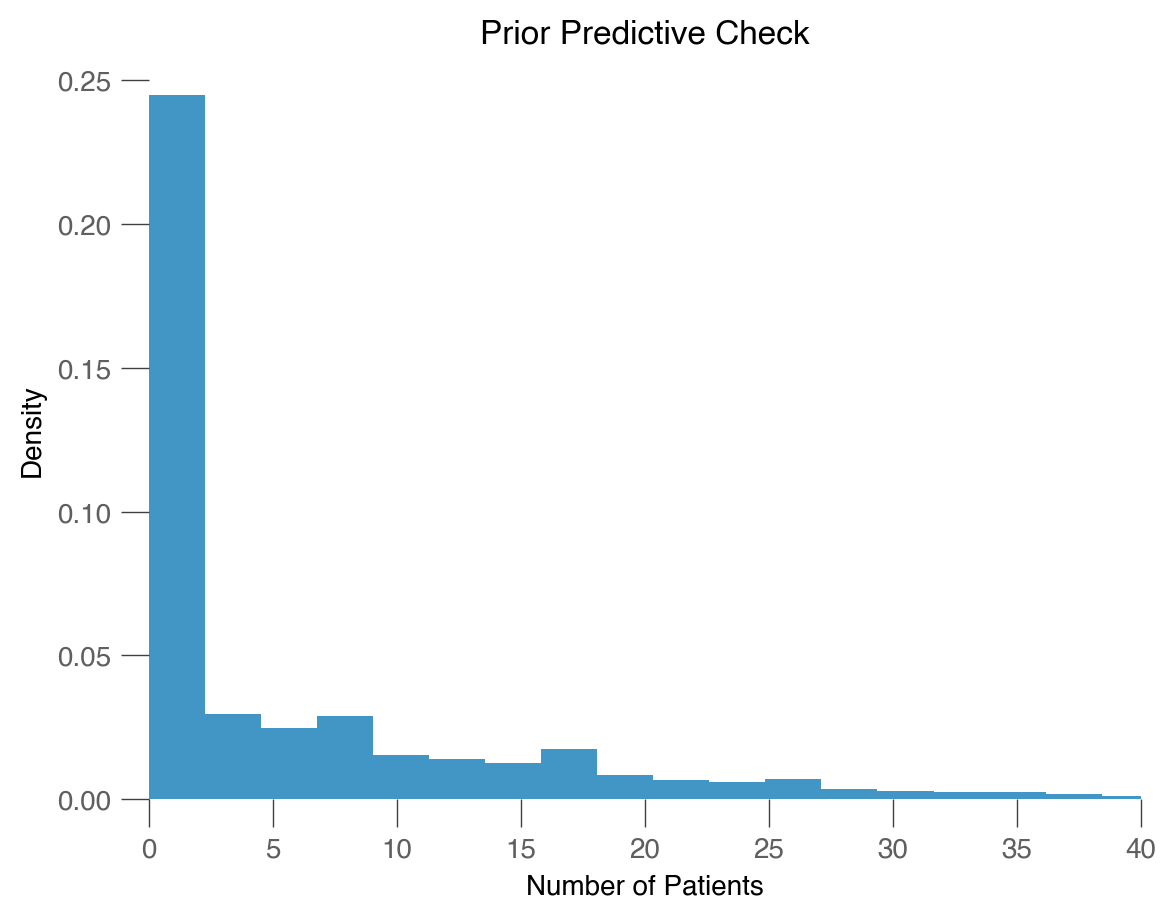

In [13]:
# Extract the likelihood samples
likelihood_samples = idata_prior_pred.prior_predictive.y_obs
flattened_array = np.ravel(likelihood_samples.values)

# Plot the prior predictive samples
plt.hist(flattened_array, bins=100, density=True, alpha=0.75)
plt.xlabel('Number of Patients')
plt.ylabel('Density')
plt.title('Prior Predictive Check')
plt.xlim(0, 40);

Eseguiamo ora il campionamento.

In [14]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...
Compilation time =  0:00:30.436998
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]







Running chain 3: 100%|██████████| 2000/2000 [00:03<00:00, 568.89it/s]


Sampling time =  0:00:03.954465
Transforming variables...
Transformation time =  0:00:00.044616


Otteniamo un sommario delle distribuzioni a posteriori. Si noti che otteniamo una distribuzione a posteriori per il tasso di occorrenza nel suo complesso, oltre alla stima del tasso di occorrenza per ciascuna regione.

In [15]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
h_mu,9.67,1.86,6.54,12.79,0.05,0.04,2081.15,1232.89,1.0
h_sigma,3.39,2.30,0.98,6.84,0.07,0.05,1804.20,1458.81,1.0
lam[1],9.29,0.54,8.37,10.42,0.01,0.01,4457.42,3052.07,1.0
lam[2],6.14,0.45,5.34,7.03,0.01,0.00,4539.60,2969.27,1.0
lam[3],9.54,0.55,8.48,10.52,0.01,0.01,4641.20,3136.93,1.0
lam[4],8.95,0.55,7.93,9.96,0.01,0.01,5226.60,2872.00,1.0
lam[5],11.87,0.61,10.74,13.03,0.01,0.01,4807.83,3189.88,1.0


I risultati presentati forniscono un riassunto delle stime a posteriori per i parametri `h_mu`, `h_sigma` e i valori di `lam` per ciascuna delle cinque regioni. Concentrandoci su ESS (Effective Sample Size) e $ r_{\hat{}} $, possiamo fare le seguenti osservazioni:

- **Effective Sample Size (ESS)**:
  - `h_mu` e `h_sigma`: Con valori di ESS bulk rispettivamente di 2271.64 e 1901.29, queste stime indicano che vi è un numero sufficiente di campioni indipendenti per effettuare affermazioni affidabili sui parametri.
  - `lam[1]` a `lam[5]`: I valori ESS per queste stime sono tutti ben al di sopra del migliaio, segnalando una buona efficienza nel campionamento e una convergenza affidabile.

- **$ r_{\hat{}} $**:
  - Per tutti i parametri, il valore di $ r_{\hat{}} $ è 1.0, il che è un segnale positivo. Un valore di $ r_{\hat{}} $ così vicino a 1 indica che le catene di Markov hanno realizzato la convergenza in modo appropriato e che non c'è evidenza di non convergenza. Questo implica che i risultati sono affidabili e che le inferenze possono essere fatte con confidenza.

In sintesi, sia l'ESS che i valori di $ r_{\hat{}} $ per questi parametri suggeriscono che il modello ha campionato efficacemente lo spazio dei parametri, e che le stime a posteriori sono attendibili. Le stime di `h_mu` e `h_sigma` ci forniscono un'indicazione chiara dell'incertezza a priori sulla media e sulla deviazione standard della distribuzione gamma del tasso di occorrenza, mentre i valori per `lam` ci offrono le stime a posteriori del tasso di occorrenza nelle diverse regioni.

È importante notare che, sebbene la stima del tasso di occorrenza possa apparire simile a quella ottenuta con il modello non gerarchico, il modello gerarchico fornisce un intervallo di credibilità decisamente più stretto per la stima di questo parametro rispetto al modello non gerarchico. Questo aspetto rivela che, utilizzando il modello non gerarchico e trascurando quindi la struttura raggruppata dei dati, si finisce per sovrastimare l'incertezza della nostra stima del parametro di interesse. In altre parole, il modello gerarchico tiene conto delle correlazioni tra i gruppi, offrendo una rappresentazione più realistica dell'incertezza nella stima del tasso di occorrenza.

Inoltre, abbiamo ottenuto una stima del tasso di occorrenza separatamente per ciascuna regione. Si noti che ci sono grandi variazioni tra le regioni. Nella regione 5, il numero medio di pazienti per psicologo è quasi 12, mentre nella regione 2 questo valore si riduce alla metà.

Nella figura seguente, i medesimi dati sono rappresentati mediante un "forest plot" del parametro `rate`, che rappresenta il numero di pazienti per ciascuno psicoloog, insieme all'intervallo di credibilità Highest Density Interval (HDI) al 94%. 

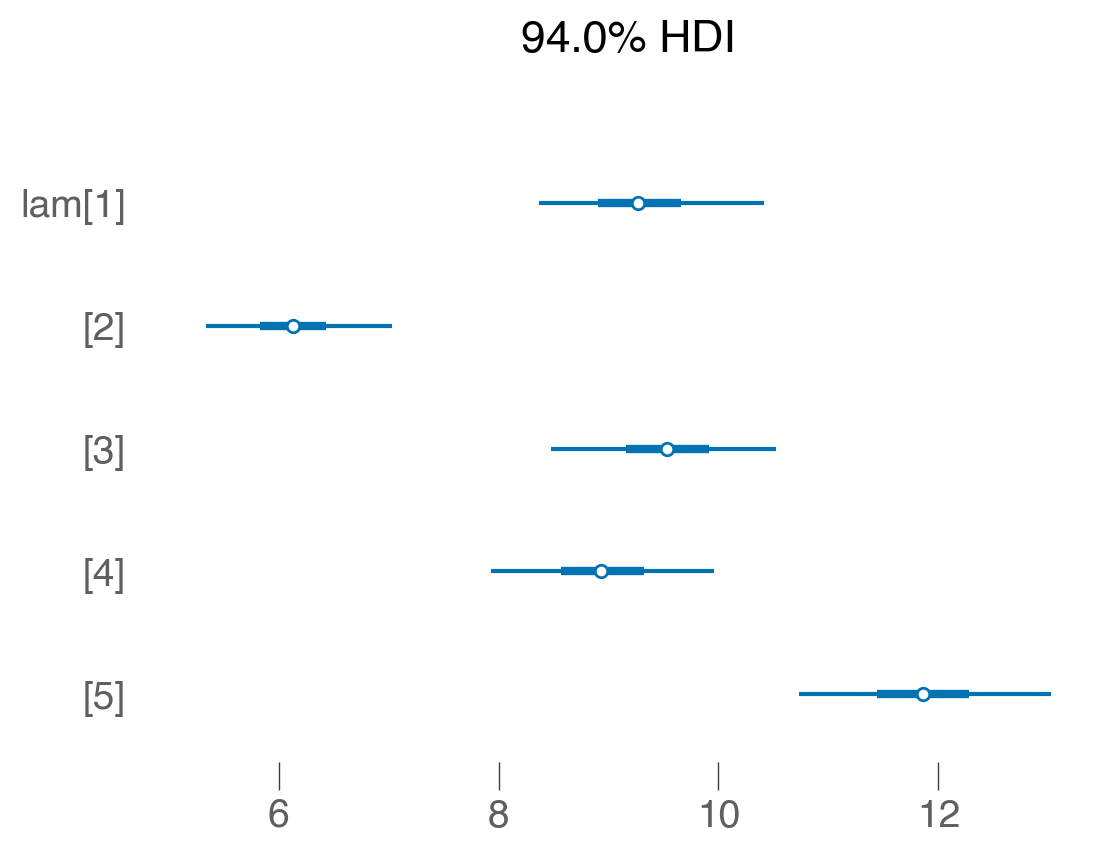

In [16]:
samples_lam = idata.posterior["lam"]
az.plot_forest(samples_lam, combined=True, hdi_prob=0.94);

Esaminiamo ora una rappresentazione grafica della distribuzione a posteriori dei parametri `h_mu` e `h_sigma`, che rappresentano l'incertezza sulla media e sulla deviazione standard della distribuzione gamma del parametro "tasso di occorrenza". Nel contesto del nostro modello gerarchico:

- **`h_mu`** è l'iper-parametro che rappresenta la media a priori della distribuzione gamma del tasso di occorrenza.
- **`h_sigma`** è l'iper-parametro che rappresenta la deviazione standard a priori della distribuzione gamma del tasso di occorrenza.

La visualizzazione delle distribuzioni a posteriori e delle tracce si può ottenere con il seguente comando.

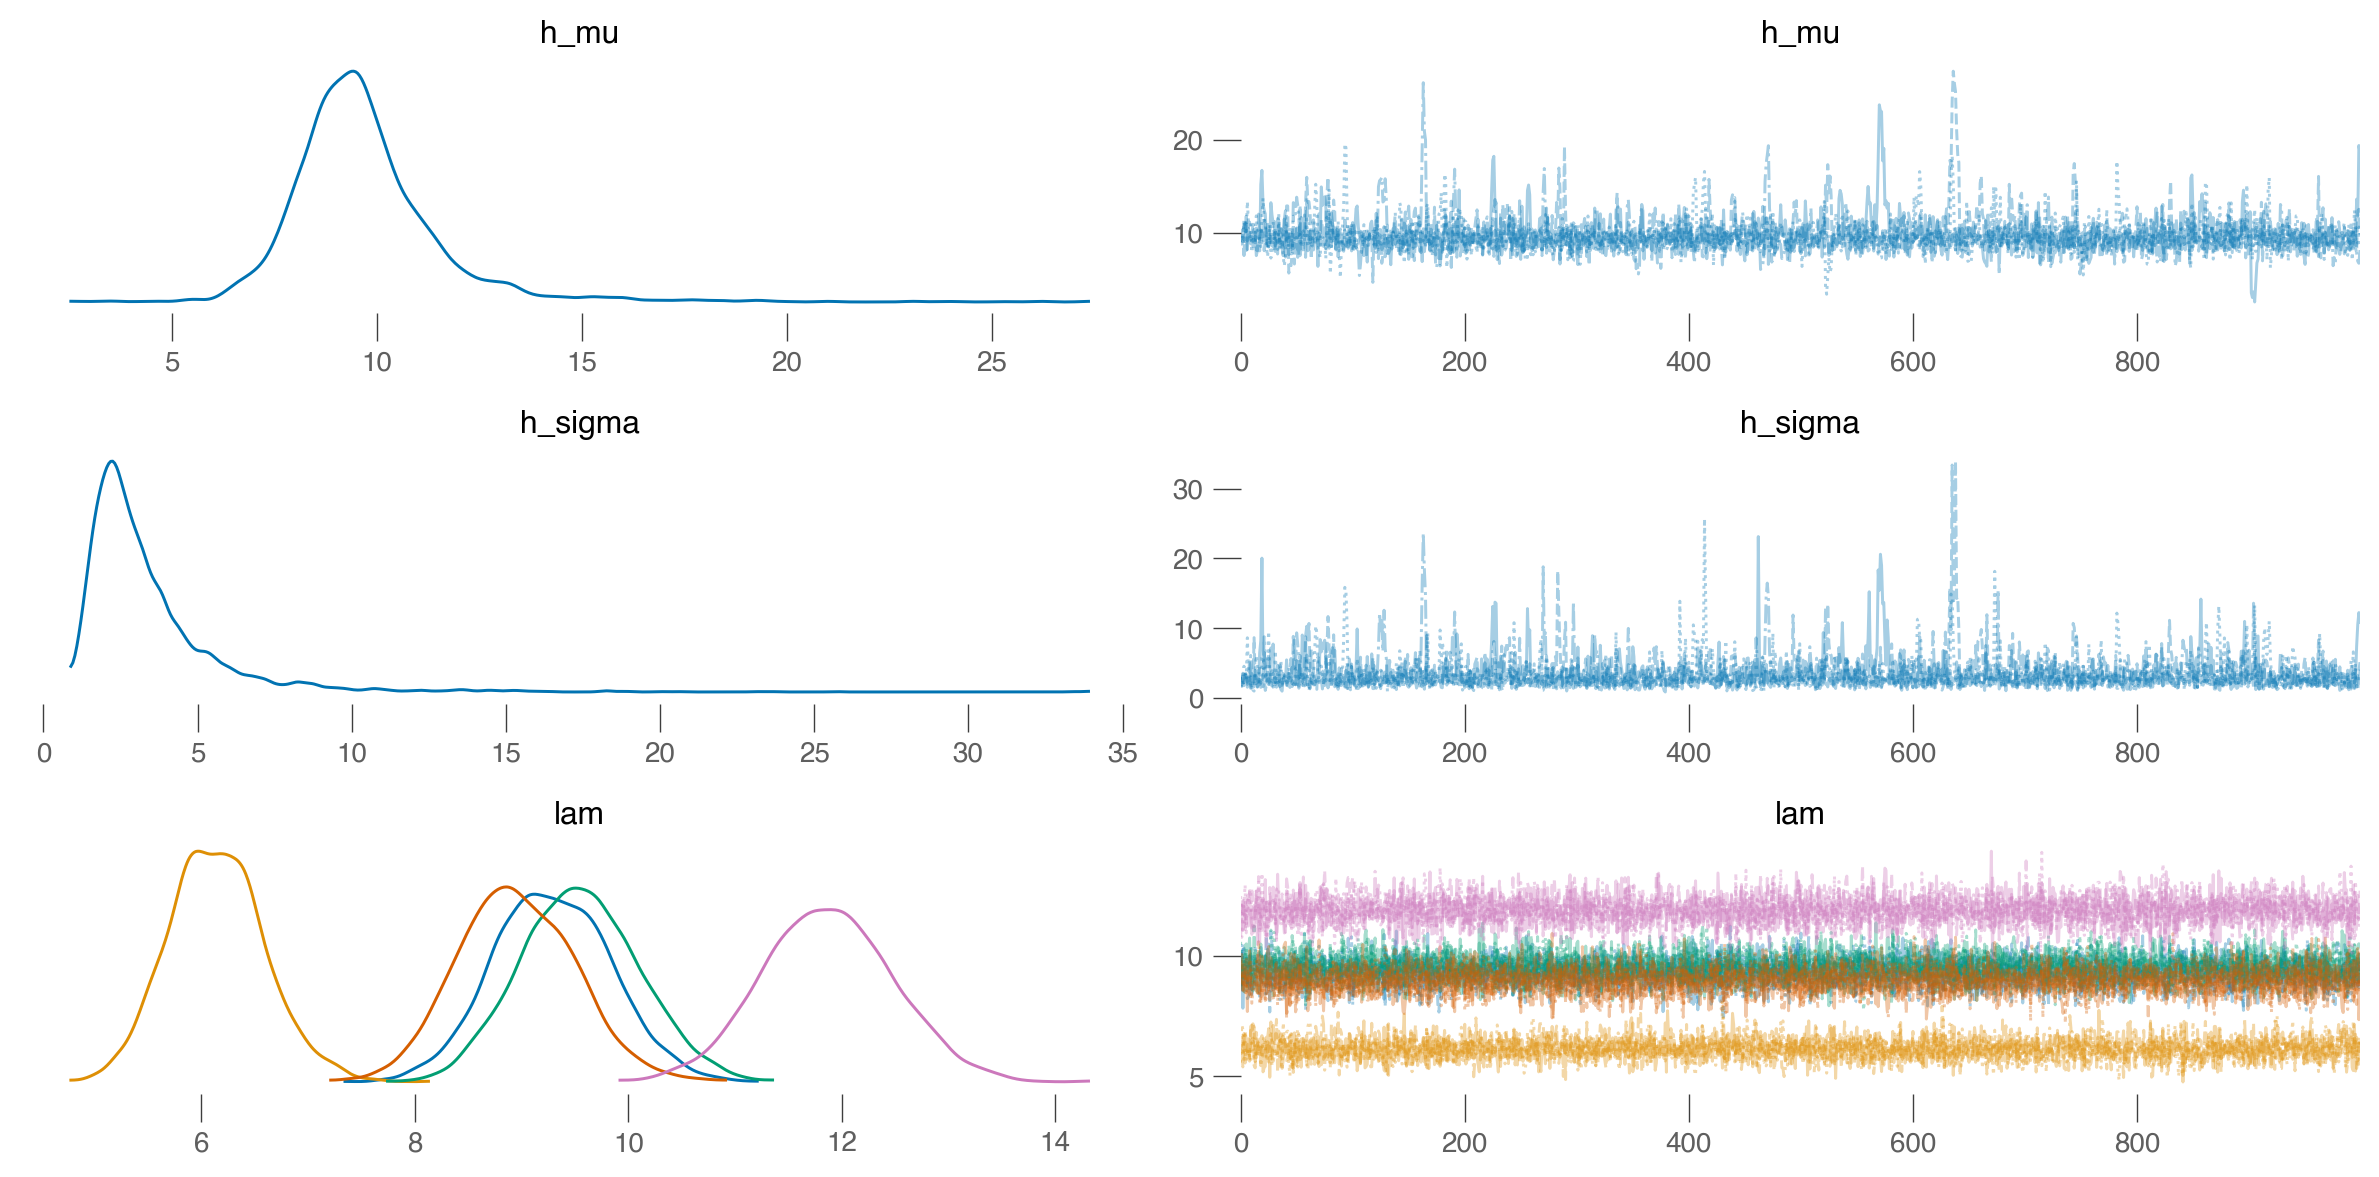

In [17]:
az.plot_trace(idata, combined=True)
plt.tight_layout();

Concludiamo, infine, con il posterior predictive check.

In [29]:
with model:
    post_pred = pm.sample_posterior_predictive(idata)

Sampling: [y_obs]


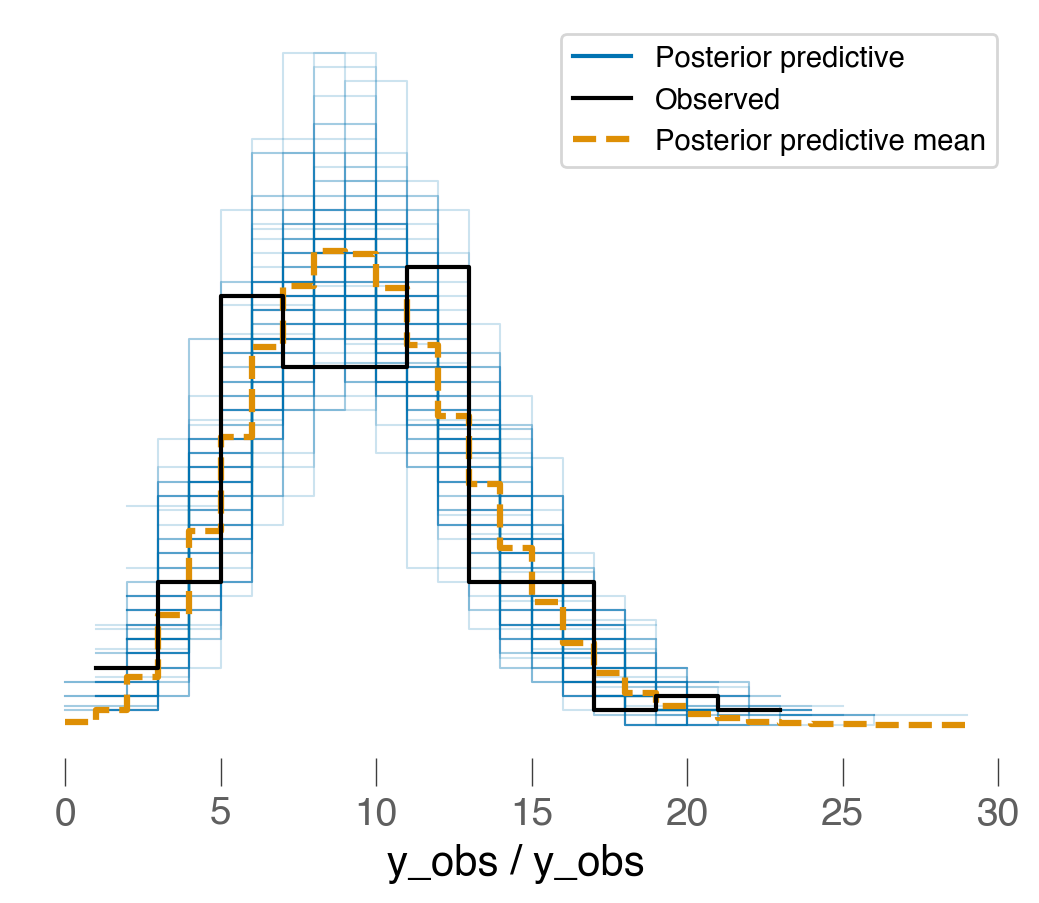

In [30]:
az.plot_ppc(post_pred, num_pp_samples=100);

Il controllo predittivo a posteriori mostra che il modello è stato in grado di rappresentare adeguatamente i dati osservati. Questo indica una buona adattabilità del modello, confermando che le supposizioni fatte e la struttura del modello sono coerenti con le informazioni ricavate dai dati.

## Watermark

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sat Aug 26 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

pytensor: 2.14.2

scipy     : 1.11.2
arviz     : 0.16.1
seaborn   : 0.12.2
numpy     : 1.25.2
matplotlib: 3.7.2
pymc      : 5.7.2
pandas    : 2.0.3

Watermark: 2.4.3

